# Time Series: Predict the Web Traffic


This notebook aims to present a solution to the hacker rank's "Predict the Web Traffic" [2] problem. We have to predict the number of sessions in a website for the next 30 days given a time series of 500 previous days. The notebook has the following sections:

1. Acquiring Data
2. Exploratory Data Analysis
3. Data Preparation
4. Time Series Modeling
5. Results
6. Conclusions
7. References

## 1. Acquiring Data 

Data is available in [6]. The zip file was downloaded and extracted in '/input' and '/output' folder. It contains one file for training data: 'input/input01.txt' and one file for test data: 'output/output01.txt'. The cells below are importing some useful libraries and loading the data into a Pandas dataframe.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

with open('input\input01.txt','r') as file:
    text = [int(number.rstrip()) for number in file.readlines()]
text.pop(0)

500

In [4]:
import pandas as pd

dates = pd.date_range(start='2012-10-1', periods=500) #create a dates periods
web_traffic = pd.DataFrame(data=text, index=dates, columns=['sessions']) #data + periods dataFrame
web_traffic.head(10)

,sessions
2012-10-01,1339
2012-10-02,1462
2012-10-03,1702
2012-10-04,1656
2012-10-05,1439
2012-10-06,1208
2012-10-07,1613
2012-10-08,1935
2012-10-09,1964
2012-10-10,2003


## 2. Exploratory Data Analysis
First, we will plot the data and a histogram to have a better visualization.

In [5]:
web_traffic.describe()

,sessions
count,500.000000
mean,1563.060000
std,531.996064
min,475.000000
25%,1155.000000
50%,1495.000000
75%,1874.500000
max,3142.000000


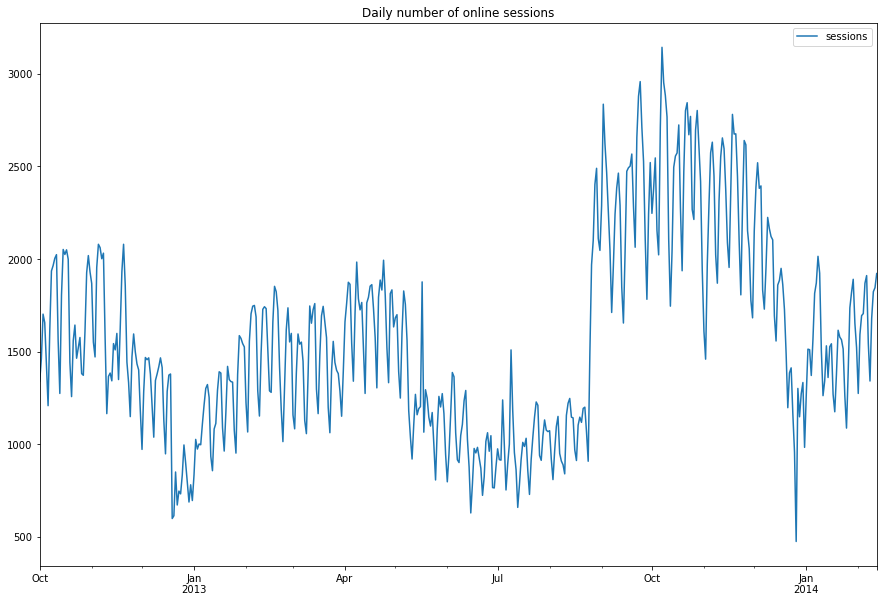

In [6]:
web_traffic.plot(figsize=(15,10))
plt.title('Daily number of online sessions')
plt.show()

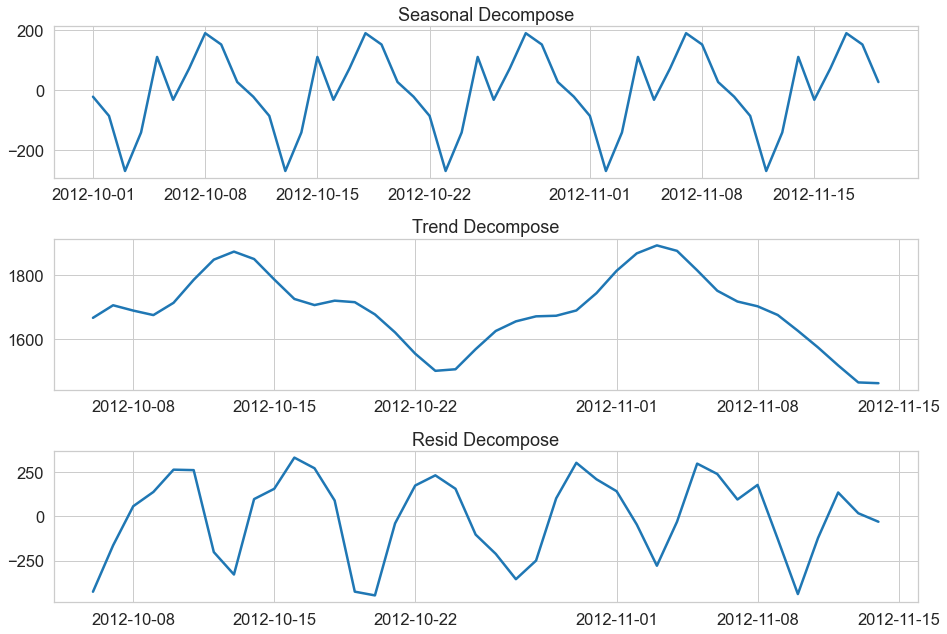

In [200]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(15,10))
result = seasonal_decompose(web_traffic[0:50], model='additive', period=10)


plt.subplot(3, 1, 1)
plt.plot(result.seasonal)
plt.title("Seasonal Decompose")
plt.subplot(3, 1, 2)

plt.plot(result.trend)
plt.title("Trend Decompose")
plt.subplot(3, 1, 3)

plt.plot(result.resid)
plt.title("Resid Decompose")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

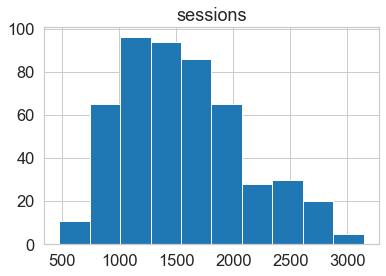

In [60]:
from scipy.stats import norm
#web_traffic.plot.kde()
web_traffic.hist()
plt.show()

Looking at this plot we can identify approximately 4 peaks each month, indicating that there is a seasonal pattern in data. The sessions number seems to start at a low value and throughout the week it increases until it reaches a peak, then it starts to decrease. The histogram shows that data is a little skewed to the right.

To visualize the autocorrelation of the observations, let's plot the ACF and PACF.

In [61]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### ACF
The autocorrelation function is a measure of the correlation between observations in a time series that are separated by k time units (yt and yt–k) [7].

The correlation and partial autocorrelation functions must be used to identify ARIMA models. You should examine the peaks of each lag to identify if they are significant. A significant peak will extend beyond the significance limits (0.05%), which indicates that the ratio for that lag is not equal to zero.

The following patterns can help specify autoregressive and MA terms in an ARIMA model.


1. A big spike at lag 1 that subsides after a few lags: An autoregressive term in the data. Use the partial autocorrelation function to determine the order of the autoregressive term.
    
2. A large peak at lag 1 followed by a falling wave that alternates between positive and negative correlations: A higher-order autoregressive term in the data. Use the partial autocorrelation function to determine the order of the autoregressive term.
    
3. Significant correlations in the first or second lag, followed by correlations that are not significant: A moving average term in the data. The number of significant correlations indicates the order of the moving average term.



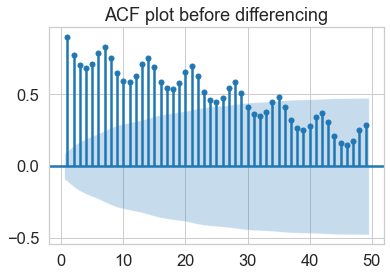

In [207]:
x = np.arange(1,50) #limitation for x axis
plot_acf(web_traffic,lags=x, use_vlines=True, title='ACF plot before differencing')
plt.show() #Case 1

### PACF
The autocorrelation function is a measure of the correlation between observations in a time series that are separated by k time units (yt and yt–k), after adjusting for the presence of all other lower lag terms (yt–1 , yt–2, ..., yt–k–1) [8].

Partial autocorrelation functions must be used to identify ARIMA models. You should examine the peaks of each lag to identify if they are significant. A significant peak will extend beyond the significance limits (0.05%), which indicates that the ratio for that lag is not equal to zero.

The following patterns can help specify autoregressive and MA terms in an ARIMA model.


1. A big spike at lag 1 that subsides after a few lags: A moving average term in the data. Use the autocorrelation function to determine the order of the moving average term.
    
2. A large peak at lag 1 followed by a falling wave that alternates between positive and negative correlations: A higher order moving average term in the data. Use the autocorrelation function to determine the order of the moving average term.
    
3. Significant correlations in the first or second lag, followed by correlations that are not significant: An autoregressive term in the data. The number of significant correlations indicates the order of the autoregressive term.


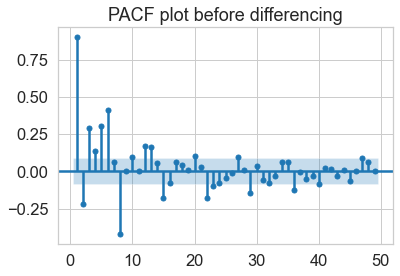

In [208]:
plot_pacf(web_traffic,lags=x, title='PACF plot before differencing')
plt.show()

In the ACF plot we can observe higher peaks at multiples of seasonal frequency __(7,14,21,28,...)__ which confirms that dataset is seasonal.

## 3. Data Preparation

To solve this problem we'll use an ARIMA model. In the ACF plot above we saw that data is not stationary (it has a seasonal component) and, to implement ARIMA, it is necessary to make the series stationary. In the cells below a seasonal differencing followed by second-order differencing is applied to eliminate seasonality.

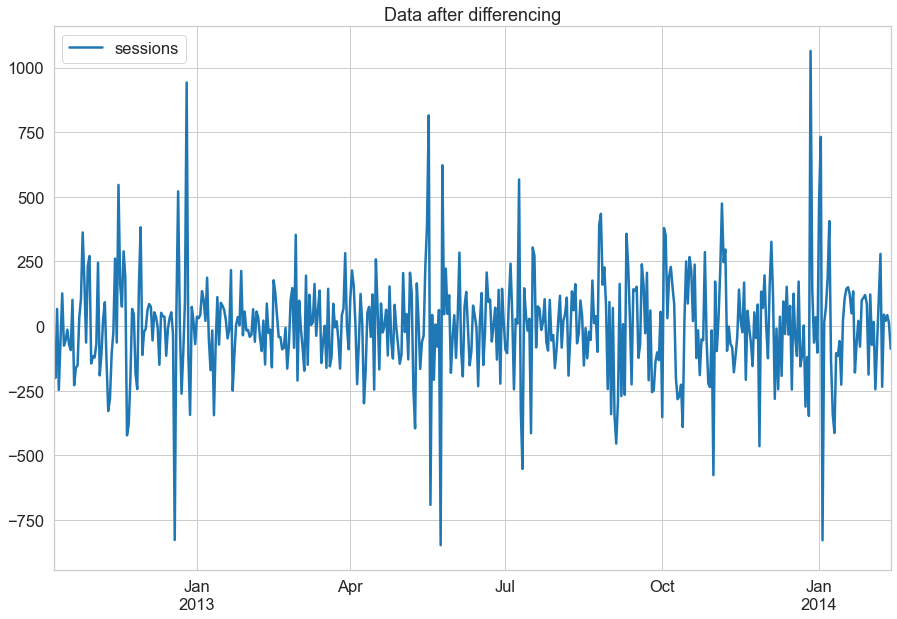

In [225]:
diff = web_traffic.diff(periods=7)
diff = diff.diff()
diff = diff.dropna()
diff.plot(figsize=(15,10))
plt.title('Data after differencing')
plt.show()

After differencing, the ACF drop to zero quickly, which is a common characteristic of stationary series.

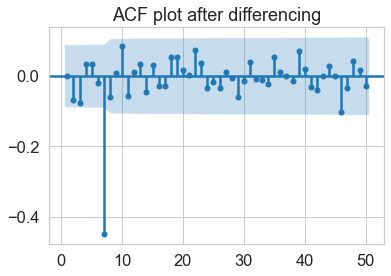

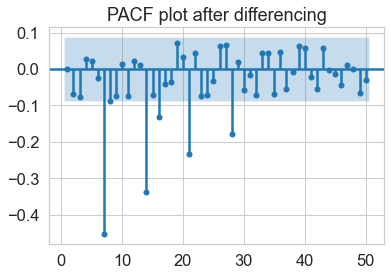

In [88]:
plot_acf(diff,lags=x, title='ACF plot after differencing')
plot_pacf(diff, lags=x, title='PACF plot after differencing')
plt.show()

To determine more objectively if the differenced data is stationary an AugmentedDickey-Fuller test is applied.

In [125]:
from statsmodels.tsa.stattools import adfuller

def stat_test(series_value):    
    #Let's check if the series is stationary:
    print("--------------------")
    stat_test = adfuller(series_value)
    test_result = pd.Series(stat_test[0:2], index = ['Test statistics', 'p-value'])
    print(test_result)
    
    if test_result[1] <= 0.05:
        print('p-value <= 0.05. The series is stationary')
    else:
        print('p-value > 0.05. The series is non-stationary')

stat_test(diff)

--------------------
Test statistics   -1.100122e+01
p-value            6.674842e-20
dtype: float64
p-value <= 0.05. The series is stationary


With this test it is possible to confirm that the differenced data is stationary.

## 4. Time Series Modeling

It is possible to estimate the Seasonal ARIMA hyperparameters by analysing the __ACF__ and __PACF__ plots of the differenced data. The ACF plot shows a spike at lag __7__ but no other significant spikes and an exponential decay in the seasonal lags of the PACF __(lags 7, 14, 21, 28)__, which caracterize an __ARIMA(0,1,0)(0,1,1)7__ model as described in section 8.9 [1]. To choose a model, we'll make some variations in hyperparameters and compare BIC values.

In the cells below we use the pmdarima library [5] to search for the best hyperparameters that minimize BIC value. We set that the model is seasonal with weekly frequency.

In [216]:
import pmdarima as pm

model = pm.auto_arima(df, 
                      start_p=0, 
                      start_q=0,
                      d=1,
                      max_p=2,
                      max_q=2,
                      D=1,
                      start_P=0,
                      start_Q=0,
                      max_P=2,
                      max_Q=2, 
                      m=7, 
                      seasonal=True,
                      information_criterion='bic', 
                      trace=True)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[7]             : BIC=6626.929, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : BIC=6526.932, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[7]             : BIC=6633.128, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : BIC=6481.219, Time=0.17 sec
 ARIMA(1,1,0)(2,1,1)[7]             : BIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(1,1,1)[7]             : BIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(2,1,0)[7]             : BIC=6476.897, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[7]             : BIC=6521.740, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[7]             : BIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(1,1,1)[7]             : BIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(2,1,0)[7]             : BIC=6480.640, Time=0.19 sec
 ARIMA(1,1,1)(2,1,0)[7]             : BIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(2,1,0)[7] intercept   : BIC=6483.042, Time=0.32 sec

Best model:  ARIMA(0,1,0)(2,1,0)[7]          
Total fit time: 

So the best result is ARIMA __(0,1,0)(2,1,0)[7]__. Let's train this model and plot the residuals to check if they look like white noise.

## 5. Results

In [217]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (0,1,0)
seasonal_order = (2,1,0,7)

model = SARIMAX(df, order=order,seasonal_order=seasonal_order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          sessions   No. Observations:                  500
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -3229.151
Date:                           Tue, 22 Jun 2021   AIC                           6464.301
Time:                                   13:09:04   BIC                           6476.897
Sample:                               10-01-2012   HQIC                          6469.247
                                    - 02-12-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.5932      0.034    -17.619      0.000      -0.659      -0.527
ar.S.L14      -0.3135      0.033     -9.579      0.000      -0.378      -0.249
sigma2      2.959e+04    893.455     33.121      0.000    2.78e+04    3.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.78   Jarque-Bera (JB):              1267.53
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

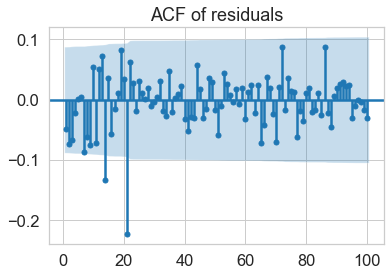

In [224]:
res = model.resid
x = np.arange(1,101)
plot_acf(res, lags=x, title='ACF of residuals')
plt.show()

Most autocorrelations are within threshold limits, indicating that residuals are behaving like white noise.
Now, we'll load test set, compute rmse and mape and plot test data along with predicted data to check performance in unseen data.

In [219]:
0

with open('output\output01.txt','r') as file:
    test = [int(number.rstrip()) for number in file.readlines()]
    
dates_test = pd.date_range(start='2014-02-13', periods=30)
df_test = pd.DataFrame(data=test, index=dates_test, columns=['real'])
df_test['predicted'] = yhat
df_test.head()

,real,predicted
2014-02-13,1808,1855.429061
2014-02-14,1454,1590.588106
2014-02-15,1393,1384.370496
2014-02-16,1733,1705.490968
2014-02-17,1944,1901.376434


In [220]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [221]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(df_test['real'].tolist(),yhat.tolist())
rmse = sqrt(mse)
print('rmse: {}'.format(rmse))
print('mape: {}'.format(mean_absolute_percentage_error(df_test['real'].tolist(), yhat.tolist())))

rmse: 1097.7773403892395
mape: 141.9376886905377


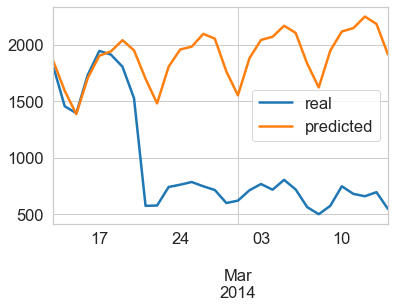

In [223]:
df_test.plot()
plt.show()

The plot above shows that the model captured the seasonality but it didn't predict the steep fall at day 17. This fall is difficult to model due to the fact that the train data doesn't have any clear trend that helps us to predict it. Other HackerRank's users also had difficulties as discussed in [3].

## 6. Conclusions
In this project we implemented a Seasonal ARIMA using pmdarima library. The model that minimized BIC value was selected and was able to capture the seasonality in data, but didn't predict the trend in test set. This was probably caused by some unknown external factors that made these numbers fall.

## 7. References
[1] Forecasting: Principles and Practice - https://otexts.com/fpp2/

[2] Time Series: Predict the Web Traffic - https://www.hackerrank.com/challenges/time-series-prediction/problem

[3] Discussion Section: Time Series: Predict the Web Traffic - https://www.hackerrank.com/challenges/time-series-prediction/forum

[4] How to Create an ARIMA Model for Time Series Forecasting in Python - https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

[5] pmdarima - https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html

[6] Time Series Web traffic Data - https://www.hackerrank.com/rest/contests/master/challenges/time-series-prediction/download_testcases

[7] ACF definition - https://support.minitab.com/pt-br/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/

[8] PACF definition - https://support.minitab.com/pt-br/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/